              T_BOTTOM  V_REFLUX     C2LPG     C5LPG
Time Minutes                                        
0                  166     10648  0.013969  0.015270
1                  166     10648  0.013969  0.015270
2                  166     10648  0.013969  0.015270
3                  166     10648  0.013969  0.015270
4                  166     10648  0.013969  0.015270
...                ...       ...       ...       ...
975                166     10648  0.013969  0.015351
976                166     10648  0.013969  0.015351
977                166     10648  0.013969  0.015350
978                166     10648  0.013969  0.015350
979                166     10648  0.013969  0.015350

[980 rows x 4 columns]


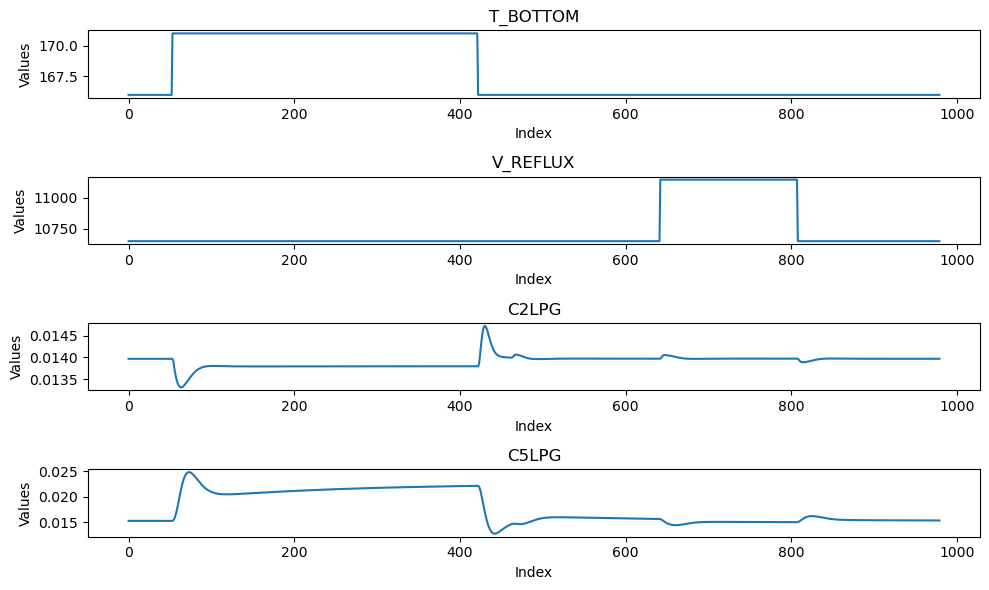

In [1]:
#!/usr/bin/env python
# coding: utf-8

from __future__ import division
from past.utils import old_div
from sippy import functionset as fset
from sippy import *
import numpy as np
import control.matlab as cnt
import matplotlib.pyplot as plt
import pandas as pd

# Step 1: Read the CSV file
df = pd.read_csv('identificationTest.csv', delimiter=";", index_col=0)
df.columns = ['T_BOTTOM', 'V_REFLUX', 'C2LPG', 'C5LPG']
print(df)

# Number of columns to plot
num_columns = len(df.columns)

# Creating subplots
fig, axs = plt.subplots(num_columns, 1, figsize=(10, 6))  # Adjust figsize as needed

# Plotting each column on a separate subplot
for i, column in enumerate(df.columns):
    axs[i].plot(df.index, df[column])
    axs[i].set_title(column)
    axs[i].set_xlabel('Index')
    axs[i].set_ylabel('Values')

plt.tight_layout()  # Adjust layout to not overlap subplots
plt.show()

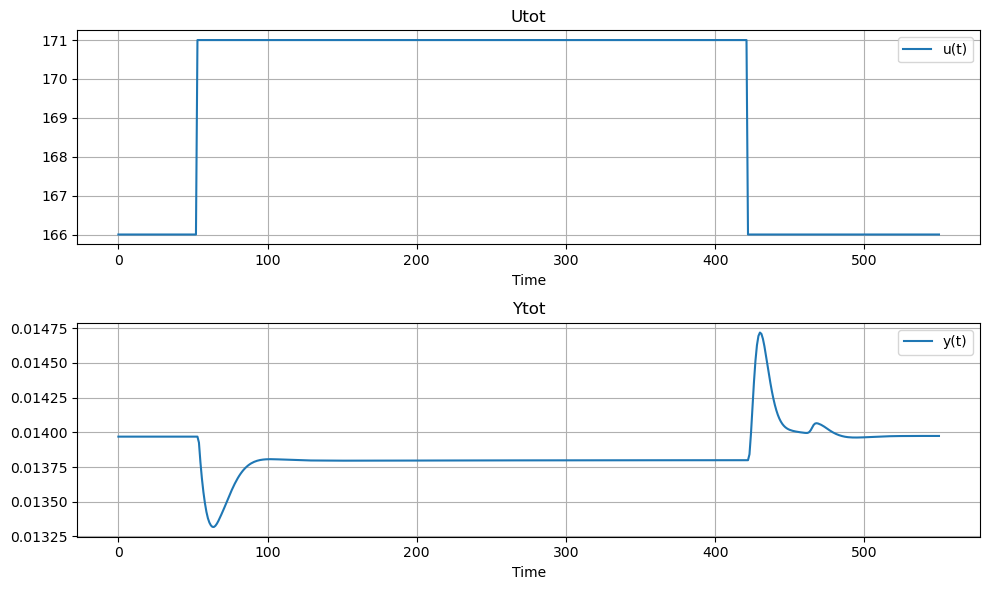

In [2]:
# MV1 CV1

# Define sampling time and Time vector
sampling_time = 1.                  
end_time = 550                      
npts = int(old_div(end_time, sampling_time)) + 1
Time = np.linspace(0, end_time, npts)
import matplotlib.pyplot as plt

# Assuming Time, df, and end_time are defined

Ytot = df['C2LPG'][0:end_time+1].to_numpy()
Utot = df['T_BOTTOM'][0:end_time+1].to_numpy()

plt.figure(figsize=(10, 6))  # Optional: Adjust the figure size

# First subplot for Utot
plt.subplot(2, 1, 1)  # (rows, columns, subplot number)
plt.plot(Time, Utot, label='u(t)')
plt.xlabel("Time")
plt.title("Utot")
plt.legend()
plt.grid()

# Second subplot for Ytot
plt.subplot(2, 1, 2)  # (rows, columns, subplot number)
plt.plot(Time, Ytot, label='y(t)')
plt.xlabel("Time")
plt.title("Ytot")
plt.legend()
plt.grid()

plt.tight_layout()  # Adjust layout to not overlap
plt.show()

In [11]:

##### SYSTEM IDENTIFICATION from collected data

# choose identification mode
mode = 'FIXED'

if mode == 'IC':
    # use Information criterion

    Id_ARMAXi = system_identification(Ytot, Utot, 'ARMAX', IC='AIC', na_ord=[4, 4], nb_ord=[3, 3],
                              nc_ord=[2, 2], delays=[11, 11], max_iterations=300, ARMAX_mod = 'ILLS')

    Id_ARMAXo = system_identification(Ytot, Utot, 'ARMAX', IC='AICc', na_ord=[4, 4], nb_ord=[3, 3],
                                      nc_ord=[2, 2], delays=[11, 11], max_iterations=300, ARMAX_mod = 'OPT')

    Id_ARMAXr = system_identification(Ytot, Utot, 'ARMAX', IC='BIC', na_ord=[4, 4], nb_ord=[3, 3],
                              nc_ord=[2, 2], delays=[11, 11], max_iterations=300, ARMAX_mod = 'RLLS')


elif mode == 'FIXED':
    # use fixed model orders

    na_ord = [4]; nb_ord = [[3]]; nc_ord = [2]; theta = [[11]]

    # ITERATIVE ARMAX
    Id_ARMAXi = system_identification(Ytot, Utot, 'ARMAX', ARMAX_orders = [na_ord, nb_ord, nc_ord, theta],
                                      max_iterations = 300, ARMAX_mod = 'ILLS')

    # OPTIMIZATION-BASED ARMAX
    Id_ARMAXo = system_identification(Ytot, Utot, 'ARMAX', ARMAX_orders = [na_ord, nb_ord, nc_ord, theta],
                                      max_iterations = 300, ARMAX_mod = 'OPT')

    # RECURSIVE ARMAX
    Id_ARMAXr = system_identification(Ytot, Utot, 'ARMAX', ARMAX_orders = [na_ord, nb_ord, nc_ord, theta],
                                      max_iterations=300, ARMAX_mod = 'RLLS')
print(type(Id_ARMAXi.G), Id_ARMAXi.G)
print(type(Id_ARMAXi.G), Id_ARMAXo.G)
print(type(Id_ARMAXi.G), Id_ARMAXr.G)

<class 'control.xferfcn.TransferFunction'> 
         4.034e-07 z^2 - 1.769e-07 z - 1.107e-07
----------------------------------------------------------
z^14 - 2.763 z^13 + 2.707 z^12 - 1.042 z^11 + 0.09894 z^10

dt = 1.0

<class 'control.xferfcn.TransferFunction'> 
        -1.191e-07 z^2 + 1.554e-06 z - 1.411e-06
---------------------------------------------------------
z^14 - 3.083 z^13 + 3.558 z^12 - 1.816 z^11 + 0.3409 z^10

dt = 1.0

<class 'control.xferfcn.TransferFunction'> 
          8.027e-07 z^2 + 7.818e-07 z - 9.821e-07
-----------------------------------------------------------
z^14 - 1.842 z^13 + 0.8303 z^12 + 0.1023 z^11 - 0.0838 z^10

dt = 1.0



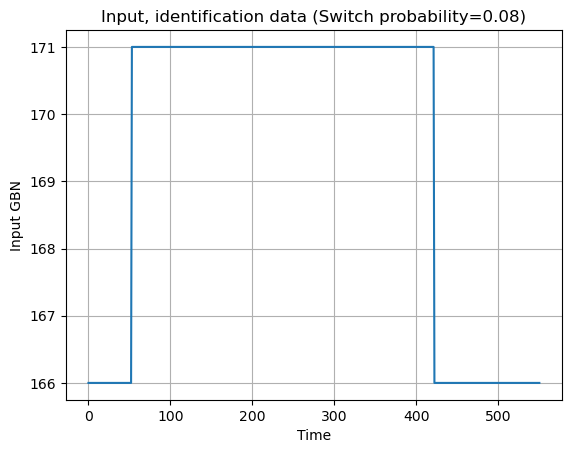

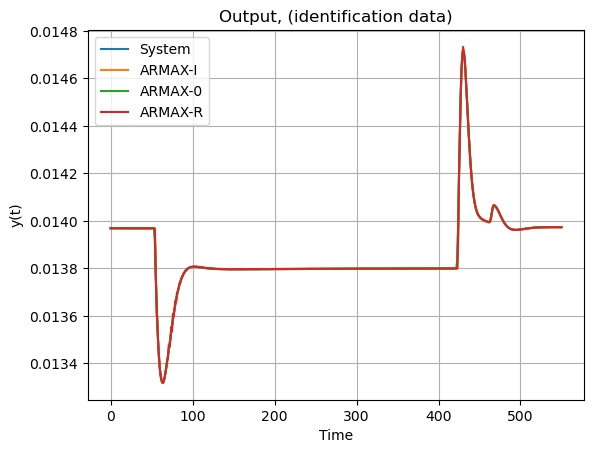

In [12]:
Y_armaxi = Id_ARMAXi.Yid.T
Y_armaxo = Id_ARMAXo.Yid.T
Y_armaxr = Id_ARMAXr.Yid.T

# ## Check consistency of the identified system

plt.figure(3)
plt.plot(Time, Utot)
plt.ylabel("Input GBN")
plt.xlabel("Time")
plt.title("Input, identification data (Switch probability=0.08)")
plt.grid()
plt.show()

plt.figure(4)
plt.plot(Time, Ytot)
plt.plot(Time, Y_armaxi)
plt.plot(Time, Y_armaxo)
plt.plot(Time, Y_armaxr)
plt.grid()
plt.xlabel("Time")
plt.ylabel("y(t)")
plt.title("Output, (identification data)")
plt.legend(['System', 'ARMAX-I', 'ARMAX-0', 'ARMAX-R'])
plt.show()

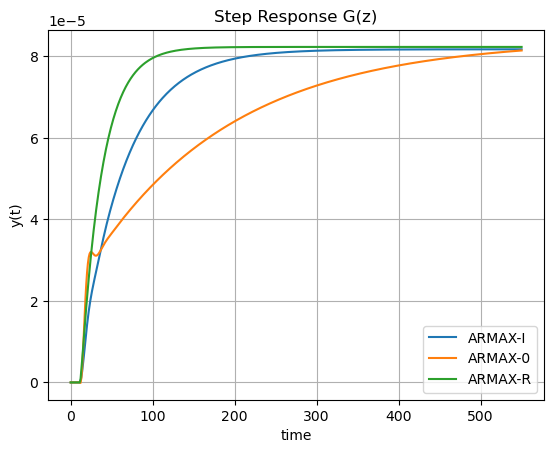

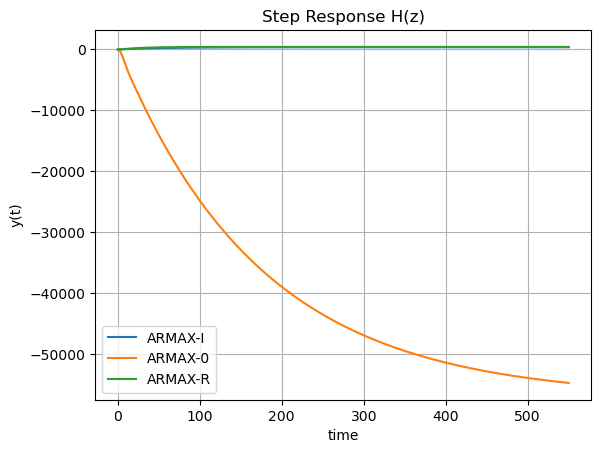

In [16]:
## Step test
# G(z)
plt.figure(9)
yg2 = cnt.step(Id_ARMAXi.G,Time)
yg3 = cnt.step(Id_ARMAXo.G,Time)
yg4 = cnt.step(Id_ARMAXr.G,Time)
plt.plot(Time,yg2[0].T)
plt.plot(Time,yg3[0].T)
plt.plot(Time,yg4[0].T)
plt.title("Step Response G(z)")
plt.xlabel("time"),plt.ylabel("y(t)"), plt.grid(),
plt.legend(['ARMAX-I', 'ARMAX-0', 'ARMAX-R'])
# H(z)
plt.figure(10)
yh2 = cnt.step(Id_ARMAXi.H,Time)
yh3 = cnt.step(Id_ARMAXo.H,Time)
yh4 = cnt.step(Id_ARMAXr.H,Time)
plt.plot(Time,yh2[0].T)
plt.plot(Time,yh3[0].T)
plt.plot(Time,yh4[0].T)
plt.title("Step Response H(z)")
plt.xlabel("time"),plt.ylabel("y(t)"), plt.grid(),
plt.legend(['ARMAX-I', 'ARMAX-0', 'ARMAX-R'])